#Урок 6. Сегментация

__1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете.__

 


In [1]:
# Импорт необходимых библиотек
##############################################
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image
import tensorflow as tf

import cv2


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

In [2]:
# Монтируем ГуглДиск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Маршрут для чтения
PATH_images = '/content/drive/MyDrive/Нейронные сети/images_/'
PATH_labels = '/content/drive/MyDrive/Нейронные сети/labels_/'

In [4]:
# Читаем имена файлов из рабочего каталога
import os, fnmatch
imag = os.listdir(PATH_images)
imag_label = os.listdir(PATH_labels)

In [5]:
imag,imag_label

(['00001.png',
  '00020.png',
  '00030.png',
  '00040.png',
  '00050.png',
  '00100.png',
  '00150.png',
  '00200.png',
  '00350.png',
  '00400.png',
  '00500.png',
  '00300.png',
  '00600.png',
  '00750.png',
  '01000.png',
  '01250.png',
  '01500.png',
  '01750.png',
  '02000.png',
  '02500.png'],
 ['00001.png',
  '00020.png',
  '00030.png',
  '01000.png',
  '00040.png',
  '00100.png',
  '00050.png',
  '00600.png',
  '00150.png',
  '00200.png',
  '02500.png',
  '00750.png',
  '01250.png',
  '00300.png',
  '00350.png',
  '00400.png',
  '01500.png',
  '00500.png',
  '01750.png',
  '02000.png'])

In [6]:
# Загружаем и уменьшаем картинки
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PATH_images+i_name ,target_size = image_size))
  segments.append(image.load_img(PATH_labels+i_name, target_size = image_size))

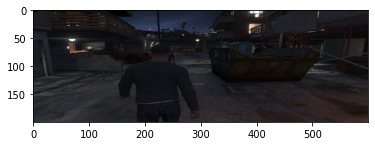

In [7]:
# Bходные кадры
plt.imshow(images[0].convert('RGBA'))
plt.show()

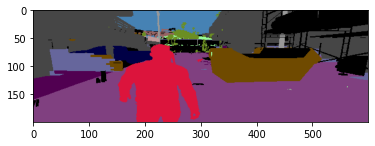

In [8]:
# Цели
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [9]:
#Создаём обучающую выборку
#####################################
# Собираем входные примеры
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [10]:
print(xTrain_Test.shape)

(20, 200, 600, 3)


__Color Coding:__

_Name (r,g,b) 7-Class mapping_

Car ( 0, 0,255) Object

Road (255, 0, 0) Road

Mark (255,255, 0) Road

Building ( 0,255, 0) Building

Sidewalk (255, 0,255) Road

Tree/Bush ( 0,255,255) Tree/Bush

Pole (255, 0,153) Sign/Pole

Sign (153, 0,255) Sign/Pole

Person ( 0,153,255) Object

Wall (153,255, 0) Building

Sky (255,153, 0) Sky

Curb ( 0,255,153) Road

Grass/Dirt ( 0,153,153) Grass/Dirt

Void ( 0, 0, 0) Void


__Improved Color Coding:__

_Name (r,g,b) 18-Class mapping_

Road (128,64,128)

Building (70,70,70)

Sky (70,130,180)

Sidewalk (244,35,232)

Vegetation(107,142,35)

Car (0,0,142)

Terrain(152,251,152)

Truck(0,0,70)

Fence(102,102,156)

Person (220,20,60)

Traffic light(250,170,30)

Motorcycle(0,0,230)

Rider(255,0,0)

Bicycle(119,11,32)

Trashcan(111,74,0)

Bridge(150,100,100)

Post(153,153,153)

Void ( 0, 0, 0) Void

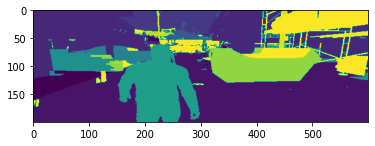

In [11]:
# конвертер в one-hot_encoding для выходных примеров
#####################################################
def Color2index(y):
  #y - входное изображение разметки (УхХхС - цветное )
  # карту цветов y_ind
  # карту ответов one-hot-encoding y_cat

  # список актуальных цветов разметки
  arr_col=[[128,64,128],[70,70,70],[70,130,180],[244,35,232],[107,142,35],[0,0,142],
           [152,251,152],[0,0,70],[102,102,156],[220,20,60],[250,170,30],[0,0,230],
           [255,0,0],[119,11,32],[111,74,0],[150,100,100],[153,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    #найдем все точки цвета i_color
    ind_i = np.where((y[:,:,0] == i_color[0]) & (y[:,:,1] == i_color[1]) & (y[:,:,2] == i_color[2]))
    
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

In [12]:
# Проверяем максимальное значение слоя 1 (по нашей схеме должна быть 1)
np.max(cat_yi[:,:,1] )

1.0

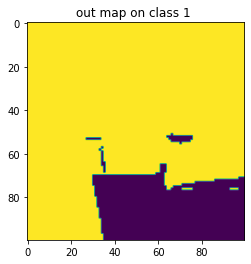

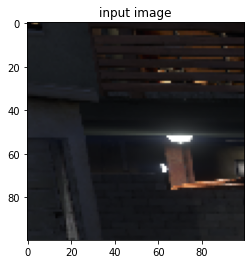

In [13]:
# маленький фрагмент карты ответов для сети 
plt.imshow(cat_yi[:100,:100,1])
plt.title('out map on class 1 ')
plt.show()
plt.imshow(xTrain_Test[0,:100,:100,:]/255)
plt.title('input image')
plt.show()

In [14]:
# Оценим размер карты ответа:
# -   число каналов равно числу классов
# -   размер карты равер размеру картинки входа
cat_yi.shape

(200, 600, 18)

In [15]:
# Сегментированную картинку в One hot encoding (разметка на 18 классов)
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [16]:
print(yTrain_Test.shape)

(20, 200, 600, 18)


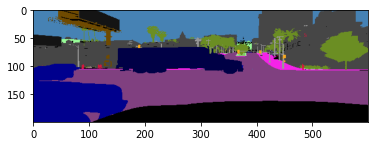

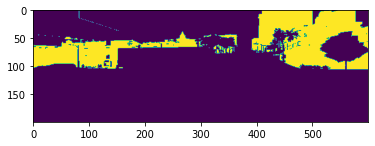

In [17]:
n = 1
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:,:,n]
plt.imshow(img.astype(float))
plt.show()

In [18]:
# Делим на тест и трейн по числу N
N = 17
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [19]:
yTest.shape

(3, 200, 600, 18)

In [20]:
print(xTrain.shape)
print(yTrain.shape)

(17, 200, 600, 3)
(17, 200, 600, 18)


In [21]:
# Создаём и обучаем U-net
##########################
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
  #num_classes = 14, - число классов ответа
  #input_shape= (200, 600, 3) - размер входной картинки

  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 200, 600, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

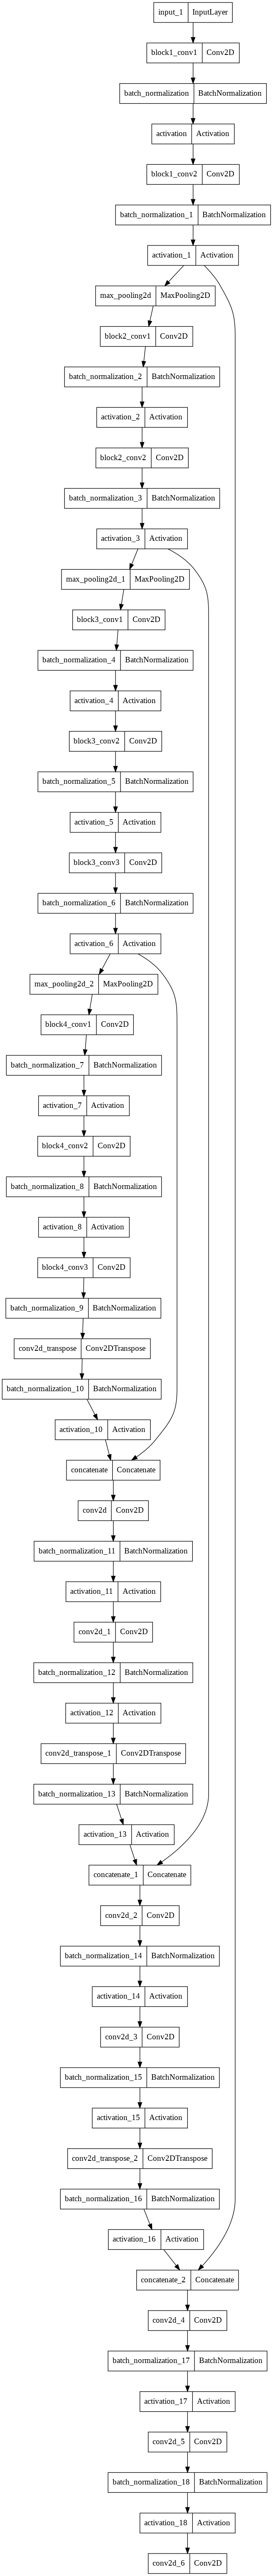

In [22]:
model = Unet(18, (200, 600, 3))

plot_model(model, to_file='modelC.png')

In [23]:
# Обучаем модель
history = model.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data = (xTrain, yTrain))

Epoch 1/10
17/17 [==============================] - 19s 212ms/step - loss: 1.8318 - dice_coef: 0.3551 - val_loss: 2260.8306 - val_dice_coef: 0.1493
Epoch 2/10
17/17 [==============================] - 3s 174ms/step - loss: 1.3062 - dice_coef: 0.4830 - val_loss: 91.3453 - val_dice_coef: 0.1010
Epoch 3/10
17/17 [==============================] - 3s 174ms/step - loss: 1.1945 - dice_coef: 0.5248 - val_loss: 129.6138 - val_dice_coef: 0.1493
Epoch 4/10
17/17 [==============================] - 3s 174ms/step - loss: 1.1485 - dice_coef: 0.5264 - val_loss: 31.4415 - val_dice_coef: 0.1577
Epoch 5/10
17/17 [==============================] - 3s 175ms/step - loss: 1.0520 - dice_coef: 0.5767 - val_loss: 8.6607 - val_dice_coef: 0.2071
Epoch 6/10
17/17 [==============================] - 4s 213ms/step - loss: 1.0136 - dice_coef: 0.5774 - val_loss: 40.6283 - val_dice_coef: 0.1855
Epoch 7/10
17/17 [==============================] - 4s 213ms/step - loss: 0.9528 - dice_coef: 0.5826 - val_loss: 10.9407 - val_

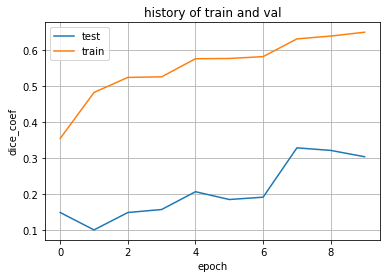

In [24]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.title('history of train and val')
plt.show()

In [25]:
# Тест модели
##########################
pred = model.predict(xTest)
print(pred.shape)

(3, 200, 600, 18)


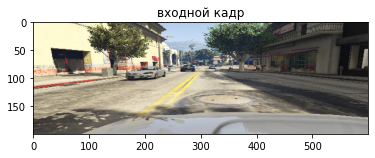

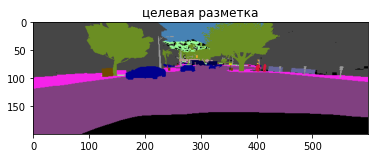

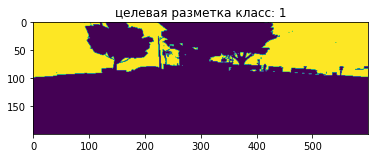

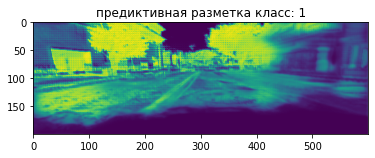

In [26]:
n = 0
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Попробуем претренированную модель:

In [27]:
# Функция увеличения разрешения bloc_transpose
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  #x, - input tensor
  #block_out, - scip tensor
  #numb_filter = [256,128] - number of kernel in layers
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [28]:
# Функция генерации модели из претернированной unet_pre_train
pre_trained_model = VGG16(input_shape=(200, 600, 3), include_top=False, weights="imagenet")

def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3), pre_trained_model = None, pretrain_out = 13,list_bloc = [10,6,3]):    
    if pre_trained_model != None:
      for layer in pre_trained_model.layers[:len(pre_trained_model.layers)]:
        layer.trainable = False
      x = pre_trained_model.layers[pretrain_out].output # конец сверток
      block_out = [pre_trained_model.layers[i].output for i in list_bloc]
     
      img_input = pre_trained_model.inputs
      print(block_out[0])
      # первое уменьшение размера
    else:
      return None  
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    for i,block_i in enumerate(block_out):
      x = bloc_transpose(x, block_i, numb_filter = [256// 2**i,128// 2**i])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

58900480/58889256 [==============================] - 1s 0us/step


In [29]:
model_U_pred = unet_pre_train(num_classes = 18, input_shape= (200, 600, 3), pre_trained_model = pre_trained_model)

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 600, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)   

In [30]:
history_pred = model_U_pred.fit(xTrain, yTrain, epochs = 30, batch_size = 3, validation_data = (xTrain, yTrain))

Epoch 1/30
6/6 [==============================] - 9s 884ms/step - loss: 2.2766 - dice_coef: 0.1790 - val_loss: 3.4235 - val_dice_coef: 0.1697
Epoch 2/30
6/6 [==============================] - 1s 207ms/step - loss: 1.5176 - dice_coef: 0.4352 - val_loss: 3.5512 - val_dice_coef: 0.1799
Epoch 3/30
6/6 [==============================] - 1s 207ms/step - loss: 1.4032 - dice_coef: 0.5063 - val_loss: 2.8142 - val_dice_coef: 0.1974
Epoch 4/30
6/6 [==============================] - 1s 208ms/step - loss: 1.3053 - dice_coef: 0.5064 - val_loss: 2.8085 - val_dice_coef: 0.1979
Epoch 5/30
6/6 [==============================] - 1s 207ms/step - loss: 1.2691 - dice_coef: 0.5022 - val_loss: 3.0792 - val_dice_coef: 0.1899
Epoch 6/30
6/6 [==============================] - 1s 208ms/step - loss: 1.1592 - dice_coef: 0.5027 - val_loss: 2.7689 - val_dice_coef: 0.1997
Epoch 7/30
6/6 [==============================] - 1s 208ms/step - loss: 1.1056 - dice_coef: 0.5440 - val_loss: 2.6040 - val_dice_coef: 0.2072
Epoch 

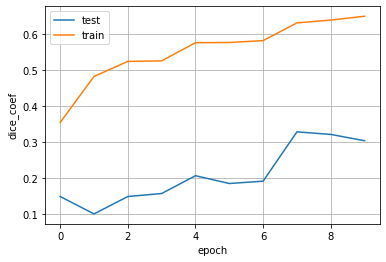

In [31]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

In [32]:
pred_u_pred = model_U_pred.predict(xTest)
print(pred_u_pred.shape)

(3, 200, 600, 18)


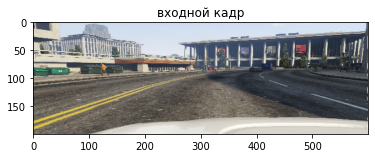

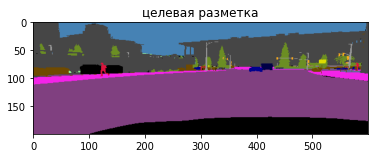

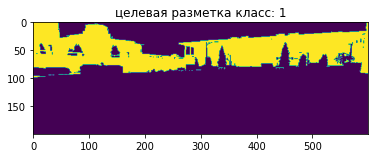

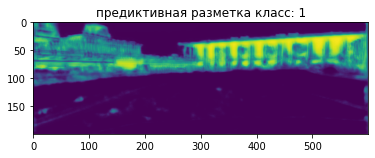

In [33]:
n = 1
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred_u_pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

Попробуем применить аугментацию:

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip= False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [35]:
# запуск data augmentation через fit_generator
model_U_pred.fit_generator(datagen.flow(xTrain, yTrain,
                                     batch_size=3),
                        epochs=30,
                        validation_data=(xTest, yTest))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


6/6 [==============================] - 2s 157ms/step - loss: 1.7527 - dice_coef: 0.4994 - val_loss: 1.1031 - val_dice_coef: 0.5255
Epoch 2/30
6/6 [==============================] - 1s 150ms/step - loss: 1.6239 - dice_coef: 0.4325 - val_loss: 1.9086 - val_dice_coef: 0.3169
Epoch 3/30
6/6 [==============================] - 1s 160ms/step - loss: 1.4499 - dice_coef: 0.4189 - val_loss: 1.4808 - val_dice_coef: 0.3727
Epoch 4/30
6/6 [==============================] - 1s 152ms/step - loss: 1.3802 - dice_coef: 0.4597 - val_loss: 1.8613 - val_dice_coef: 0.2779
Epoch 5/30
6/6 [==============================] - 1s 166ms/step - loss: 1.3602 - dice_coef: 0.4487 - val_loss: 1.2999 - val_dice_coef: 0.4044
Epoch 6/30
6/6 [==============================] - 1s 149ms/step - loss: 1.3504 - dice_coef: 0.4378 - val_loss: 1.7679 - val_dice_coef: 0.3025
Epoch 7/30
6/6 [==============================] - 1s 150ms/step - loss: 1.4198 - dice_coef: 0.4360 - val_loss: 1.6011 - val_dice_coef: 0.3366
Epoch 8/30
6/6 [=

In [36]:
history_pred_aug = model_U_pred.fit(xTrain, yTrain, epochs = 30, batch_size = 3, validation_data = (xTrain, yTrain))

Epoch 1/30
6/6 [==============================] - 1s 241ms/step - loss: 0.9690 - dice_coef: 0.5518 - val_loss: 0.9865 - val_dice_coef: 0.5526
Epoch 2/30
6/6 [==============================] - 1s 210ms/step - loss: 0.8306 - dice_coef: 0.6204 - val_loss: 0.9902 - val_dice_coef: 0.5701
Epoch 3/30
6/6 [==============================] - 1s 210ms/step - loss: 0.7442 - dice_coef: 0.6534 - val_loss: 1.0041 - val_dice_coef: 0.5562
Epoch 4/30
6/6 [==============================] - 1s 210ms/step - loss: 0.7414 - dice_coef: 0.6720 - val_loss: 0.7786 - val_dice_coef: 0.6593
Epoch 5/30
6/6 [==============================] - 1s 210ms/step - loss: 0.6749 - dice_coef: 0.6871 - val_loss: 0.7361 - val_dice_coef: 0.6694
Epoch 6/30
6/6 [==============================] - 1s 211ms/step - loss: 0.6287 - dice_coef: 0.7067 - val_loss: 0.7354 - val_dice_coef: 0.6742
Epoch 7/30
6/6 [==============================] - 1s 212ms/step - loss: 0.5888 - dice_coef: 0.7220 - val_loss: 0.6836 - val_dice_coef: 0.6891
Epoch 

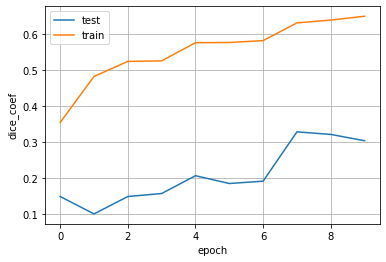

In [37]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

In [38]:
pred_u_pred_aug = model_U_pred.predict(xTest)
print(pred_u_pred_aug.shape)


(3, 200, 600, 18)


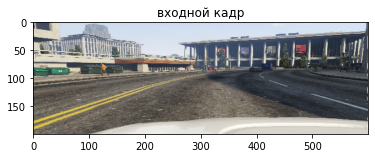

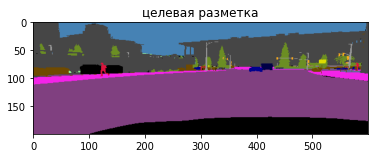

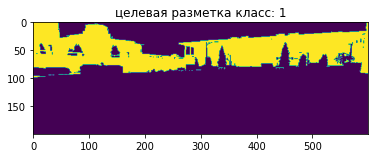

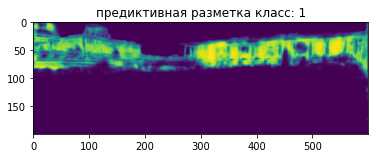

In [39]:
n = 1
class_ = 1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred_u_pred_aug[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

__2. Опишите  результат. Что помогло повысить точность?__

Для работы использовался датасет "Playing for Data: Ground Truth from Computer Games"(https://download.visinf.tu-darmstadt.de/data/from_games/index.html). Изначально из датасета было взято 12 изображений и масок к ним и применялась кодировка цветов разметки из "CityScapes dataset", так как в документации было указано, что классы этих датасетов совместимы. Однако изначальная кодировка цветов разметки давала некорректные результаты, в итоге пришлось "вручную" переписать цветовую разметку, используя цвета напрямую из размеченных изображений датасета. 

Далее улучшение результата дало применение предобученной сети "VGG16", увеличение колличества изображений до 20-ти, добавление еще одного класса цветовой разметки, отвечающего за неразмеченные участки "Void ( 0, 0, 0)" и применение аугментации.